In [10]:
import os
import numpy as np
import pandas as pd
from skimage import exposure
import matplotlib.pyplot as plt
import cv2
from ast import literal_eval

In [4]:
df_image = pd.read_csv('train_image_level.csv')
df_study = pd.read_csv('train_study_level.csv')

# merge two dataset for ease manipulation
df_study['id'] = df_study['id'].str.replace('_study', '')
df_study.rename({'id' : 'StudyInstanceUID'}, axis=1, inplace=True)
df_train = df_image.merge(df_study, on='StudyInstanceUID')

# create new col for label class
df_train.loc[df_train['Typical Appearance']==1, 'study_label'] = 'typical'
df_train.loc[df_train['Indeterminate Appearance']==1, 'study_label'] = 'indeterminate'
df_train.loc[df_train['Atypical Appearance']==1, 'study_label'] = 'atypical'
df_train.drop(['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'], axis=1, inplace=True)


df_train['id'] = df_train['id'].str.replace('_image', '.png')

# split label for just getting opacity/none label
df_train['image_label'] = df_train['label'].str.split().apply(lambda x : x[0])

df_train.head(3)

,id,boxes,label,StudyInstanceUID,study_label,image_label
0,000a312787f2.png,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,typical,opacity
1,000c3a3f293f.png,NaN,none 1 0 0 1 1,ff0879eb20ed,NaN,none
2,0012ff7358bc.png,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,typical,opacity


In [9]:
all_files = []
for dirname, _, filenames in os.walk('train'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

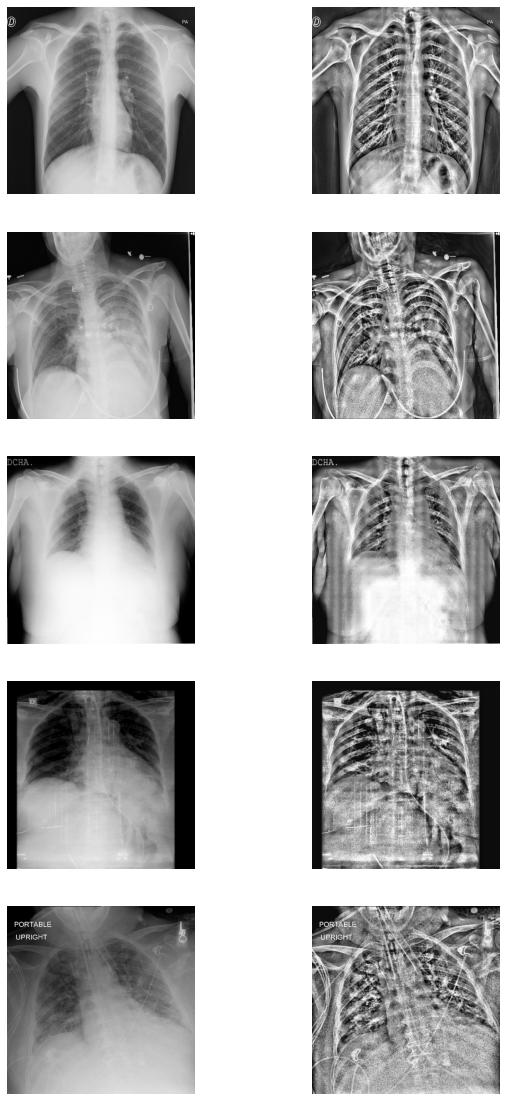

In [11]:
def preprocess_image(img):
    # python -m pip install -U scikit-image
    equ_img = exposure.equalize_adapthist(img/255, clip_limit=0.05, kernel_size=24)
    return equ_img

df_opa = df_train[df_train['image_label'] == 'opacity'].reset_index()
fig, axs = plt.subplots(5, 2, figsize=(10,20))
fig.subplots_adjust(hspace=.2, wspace=.2)
n = 5
for i in range(n):
    img = cv2.imread(os.path.join(all_files[i]))
    img_proc = preprocess_image(img)
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(img_proc)
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()